In [1]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:01<00:00, 212.33it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 1940.66it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [3]:
from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)

In [8]:
R_n = alignment.align_embeddings_batch(tar_train_data,ref_train_data,train_steps=30000)

batch_idx 0,iteration 0, loss1 65502392.0 loss2 {tensor(0.7834, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.8510, requires_grad=True)}
batch_idx 199,iteration 199, loss1 594.9434814453125 loss2 {tensor(0.5516, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5020, requires_grad=True)}
batch_idx 398,iteration 398, loss1 235.92929077148438 loss2 {tensor(0.4058, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4880, requires_grad=True)}
batch_idx 97,iteration 597, loss1 217.41969299316406 loss2 {tensor(0.3704, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4450, requires_grad=True)}
batch_idx 296,iteration 796, loss1 230.45870971679688 loss2 {tensor(0.3986, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4510, requires_grad=True)}
batch_idx 495,iteration 995, loss1 209.81378173828125 loss2 {tensor(0.3463, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.3980, requires_grad=True)}
batch_idx 194,iteration 1194, loss1 196.12322998046875 loss2 {tensor(0.3391, grad_fn=<AddBackward0>)} neibou

In [80]:
vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')

indices, grid = alignment.get_grid_align_indicates(embedding_in_ref,vis,TAR_EPOCH, 0.02,0.02)

grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
tar_np_grid_samples = np.asarray(grid_samples)

len of align: 6588


In [84]:
######### generate  reference_grid and target_grid
from alignment.TrainingSnapshotAlignmentCKA import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )
ref_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

embedding_in_ref = ref_projector.batch_project(200, ref_train_data)
indices_1, grid = alignment.get_grid_align_indicates(embedding_in_ref,vis,TAR_EPOCH, 0.025,0.025)
ref_grid_samples = ref_projector.batch_inverse(TAR_EPOCH, grid)
ref_np_grid_samples = np.asarray(ref_grid_samples)
              ##################
tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_vis = visualizer(tar_provider, I,I, tar_provider.train_representation(TAR_EPOCH), projector, 200,[0,1],'tab10')

indices, grid = alignment.get_grid_align_indicates(embedding_in_ref,tar_vis,TAR_EPOCH, 0.02,0.02)

grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
tar_np_grid_samples = np.asarray(grid_samples)

len of align: 4459
len of align: 6588


In [ ]:
indicates = np.random.choice(np.arange(40000), size=1000, replace=False)
print(ref_np_grid_samples[indicates].shape)
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(ref_train_data[indicates],tar_train_data[indicates]))
print('CKA between absolute alignmnet subset is:',np_cka.kernel_CKA(ref_np_grid_samples[indicates],tar_np_grid_samples[indicates]))

In [87]:
####### get metrix S

indicates = np.random.choice(np.arange(40000), size=2000, replace=False)

from AlignVis.AlignMetrixGenerator import TrainingSnapshotAlignment
alignment_n = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH, projector=projector, visualizer=vis)
X_for_s = np.concatenate((ref_np_grid_samples[indices[1]],ref_train_data[indicates]),axis=0)
Y_for_s = np.concatenate((tar_np_grid_samples[indices[1]],tar_train_data[indicates]),axis=0)
print(X_for_s.shape)
S_s = alignment_n.align_embeddings_batch(X_for_s,Y_for_s,train_steps=3000,batch_size=100)

(8588, 512)
batch_idx 0,iteration 0, loss1 574227328.0 loss2 {tensor(0.6313, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.6980, requires_grad=True)}
batch_idx 27,iteration 199, loss1 12776.0498046875 loss2 {tensor(0.7909, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7140, requires_grad=True)}
batch_idx 54,iteration 398, loss1 2734.16259765625 loss2 {tensor(0.6465, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.5510, requires_grad=True)}
batch_idx 81,iteration 597, loss1 1165.0426025390625 loss2 {tensor(0.8281, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.7630, requires_grad=True)}
batch_idx 22,iteration 796, loss1 852.358154296875 loss2 {tensor(0.5962, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4920, requires_grad=True)}
batch_idx 49,iteration 995, loss1 382.654052734375 loss2 {tensor(0.5258, grad_fn=<AddBackward0>)} neibour_loss {tensor(0.4660, requires_grad=True)}
batch_idx 76,iteration 1194, loss1 578.4656372070312 loss2 {tensor(0.7476, grad_fn=<AddBackward0>)} neibou

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 1691.12it/s]


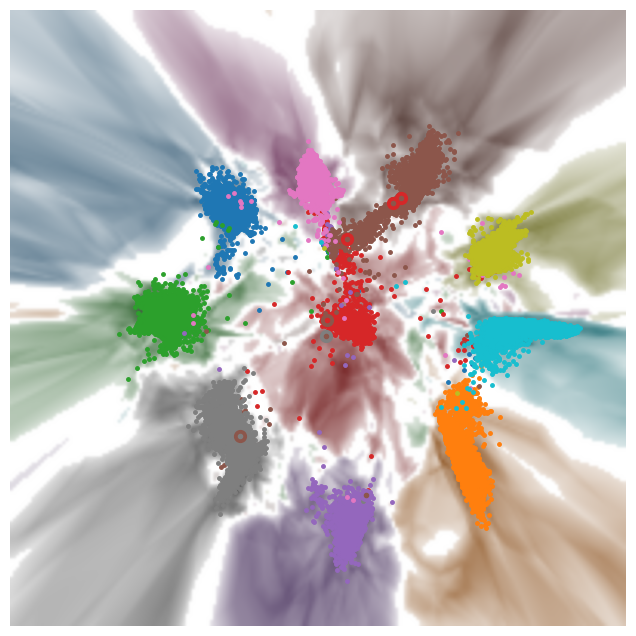

In [83]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_s.detach().numpy(),I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 1612.57it/s]


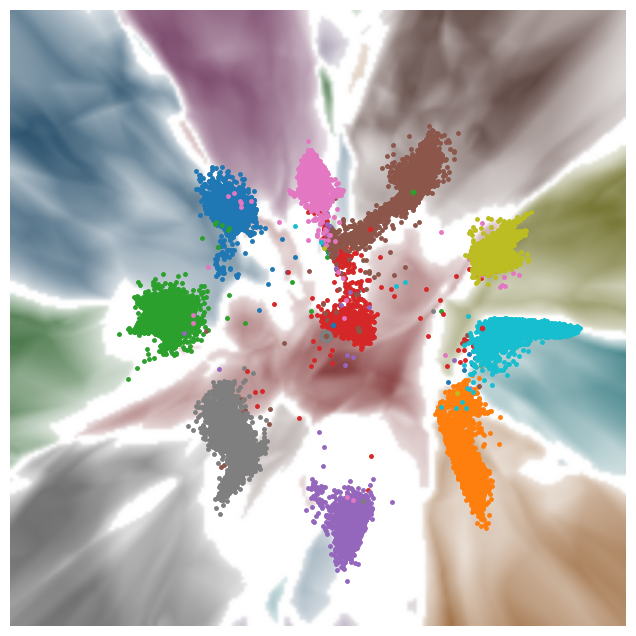

In [86]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from alignment.teet import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(tar_train_data,R_n.detach().numpy()), projector, 200,[],np.dot(tar_np_grid_samples,R_n.detach().numpy()),'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [70]:
from alignment.TrainingSnapshotAlignmentCKA import TrainingSnapshotAlignment
alignment = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )
ref_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

embedding_in_ref = ref_projector.batch_project(200, ref_train_data)
indices, grid = alignment.get_grid_align_indicates(embedding_in_ref,vis,TAR_EPOCH, 0.02,0.02)



len of align: 2878


In [ ]:
ref_grid_samples = ref_projector.batch_inverse(TAR_EPOCH, grid)
ref_np_grid_samples = np.asarray(ref_grid_samples)

tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
tar_np_grid_samples = np.asarray(tar_grid_samples)

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 1824.63it/s]


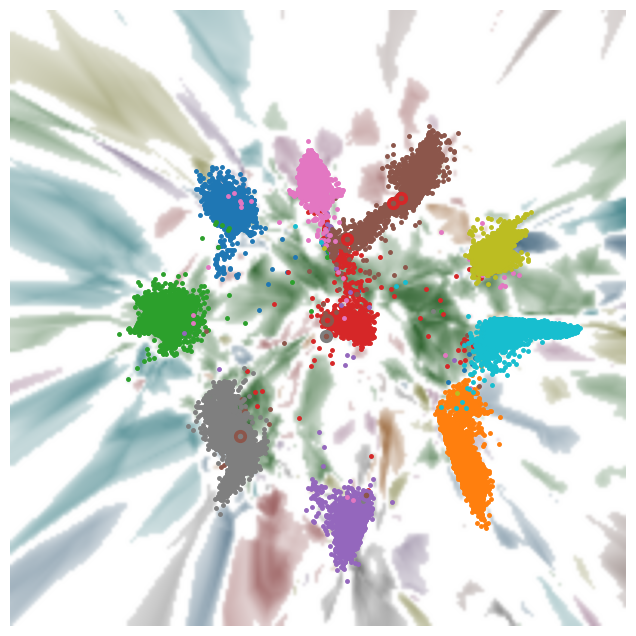

In [69]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_m.detach().numpy(),I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8146.18it/s]


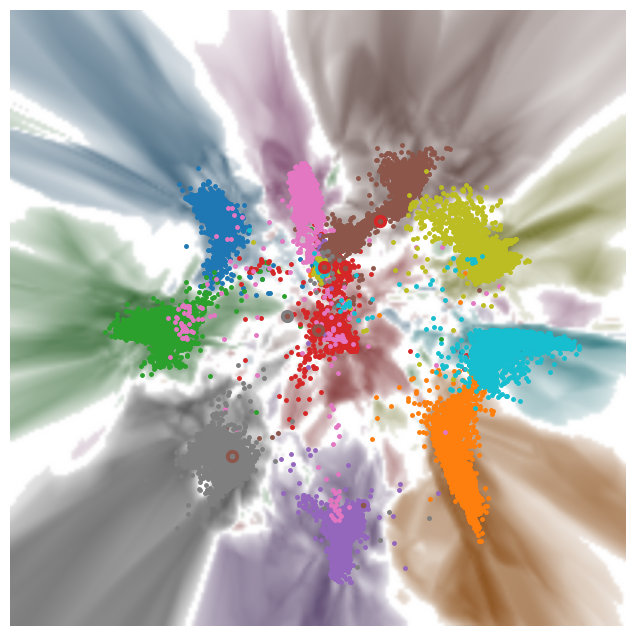

In [67]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_n.detach().numpy(),I, np.dot(tar_train_data, R_n.detach().numpy()), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 8216.33it/s]


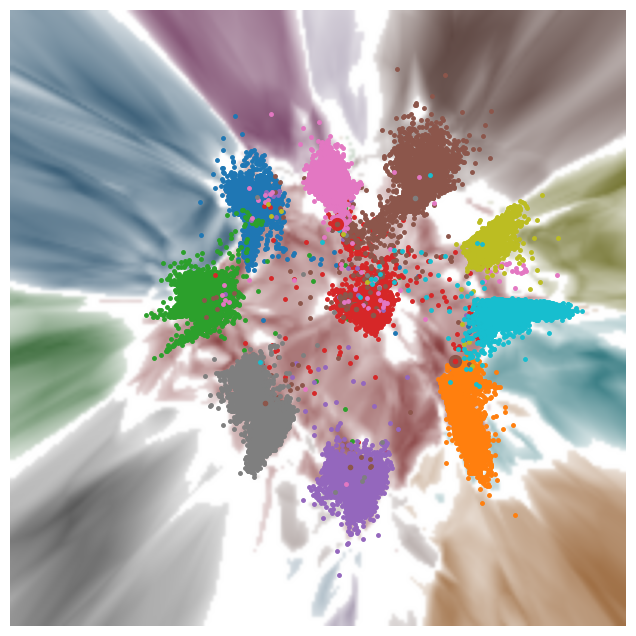

In [10]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, S_n.detach().numpy(),I, np.dot(ref_train_data,I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join("/home/yifan/projects/deepdebugertool/DLVisDebugger/alignment_evaluation/img1.png"))

In [42]:
tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_grid_samples = tar_projector.batch_inverse(TAR_EPOCH, grid)
tar_np_grid_samples = np.asarray(tar_grid_samples)

In [43]:
from typing import Tuple
X = ref_np_grid_samples
Y = tar_np_grid_samples
def remove_invalid_rows(X: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    valid_indices = np.isfinite(X).all(axis=1) & np.isfinite(Y).all(axis=1)
    
    return X[valid_indices], Y[valid_indices]

X_clean, Y_clean = remove_invalid_rows(X, Y)

In [44]:
####### dropout resnet18 vs without dropout
#### 
import torch
import sys
sys.path.append("..")
import numpy as np

CLEAN_PATH = "/home/yifan/dataset/resnet18_with_dropout/pairflip/cifar10/0/"
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"


ENCODER_DIMS=[512,256,256,256,256,2]
DECODER_DIMS= [2,256,256,256,256,512]
VIS_MODEL_NAME = 'vis'

DEVICE='cuda:1'
########## initulize reference data and target data
from alignment.data_preprocess import DataInit
REF_EPOCH = 200
TAR_EPOCH = 200
ref_datainit = DataInit(REF_PATH,REF_PATH,REF_EPOCH)
tar_datainit = DataInit(CLEAN_PATH,CLEAN_PATH,TAR_EPOCH)
ref_model, ref_provider, ref_train_data, ref_prediction, ref_prediction_res, ref_scores = ref_datainit.getData()
tar_model, tar_provider, tar_train_data, tar_prediction, tar_prediction_res, tar_scores = tar_datainit.getData()


from alignment.ReferenceGenerator import ReferenceGenerator
gen = ReferenceGenerator(ref_provider=ref_provider, tar_provider=tar_provider,REF_EPOCH=REF_EPOCH,TAR_EPOCH=TAR_EPOCH,ref_model=ref_model,tar_model=tar_model,DEVICE=DEVICE)

absolute_alignment_indicates,predict_label_diff_indicates,predict_confidence_Diff_indicates,high_distance_indicates = gen.subsetClassify(18,0.8,0.3,0.05)


from representationTrans.trans_visualizer_border import visualizer
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)

I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(TAR_EPOCH),I), projector, 200,[0,1],'tab10')


NET resnet18
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8273.12it/s]


NET resnet18_with_dropout
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8036.73it/s]


absolute alignment indicates number: 106 label diff indicates number: 12 confidence diff indicates number: 16 high distance number: 97


In [ ]:
from alignment.TrainingSnapshotAlignmentCKA import TrainingSnapshotAlignment
alignment2 = TrainingSnapshotAlignment(ref_provider, tar_provider,ref_EPOCH=REF_EPOCH,tar_EPOCH=TAR_EPOCH )